# 0. Setup

In [1]:
!nvidia-smi -L

/bin/bash: /home/maxgan/anaconda3/envs/triq/lib/libtinfo.so.6: no version information available (required by /bin/bash)
GPU 0: NVIDIA GeForce RTX 3090 (UUID: GPU-9d5e4f83-3f58-2974-ee70-21df15226f84)


In [4]:
import os
import datetime
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd


from model.vit_for_small_dataset import ViT
from utils.imageset_handler import ImageQualityDataset

# 1. Build Model

### 1.1 Define Variables

In [5]:
image_size=256
patch_size=16
num_classes=5  # Number of classes for image quality levels
dim=1024
depth=6
heads=16
mlp_dim=2048
emb_dropout=0.1


pretrained_model_path = None
num_epochs = 20
results_path = '/home/maxgan/WORKSPACE/UNI/BA/TIQ/results'

### 1.2 Compile

In [ ]:
model = ViT(
    image_size=image_size,
    patch_size=patch_size,
    num_classes=num_classes,
    dim=dim,
    depth=depth,
    heads=heads,
    mlp_dim=mlp_dim,
    emb_dropout=emb_dropout
)

### 1.3 Load pretrained weights

In [ ]:
if pretrained_model_path:
    model.load_state_dict(torch.load(pretrained_model_path))
    print(model)

# 2 Load Dataset

### 2.1 Add Augmentation (Transformation)

In [ ]:
transform = transforms.Compose([
    transforms.RandomResizedCrop(256),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet mean and std
])

### 2.2 Create Dataset

In [ ]:
dataset_root = '/home/maxgan/WORKSPACE/UNI/BA/TIQ/assets/DatasetSubjective/Persons/Person_1_shinyx/imgs'
csv_file = '/home/maxgan/WORKSPACE/UNI/BA/TIQ/assets/DatasetSubjective/Persons/Person_1_shinyx/img_scores.csv'

In [ ]:
dataset = ImageQualityDataset(csv_file,dataset_root,transform=transform)

### 2.3 Split the dataset into training and validation sets

In [ ]:
test_size = 0.2
num_train = int(len(dataset)* (1-test_size))
num_val = len(dataset) - num_train

print('Splitting Dataset..')
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [num_train, num_val])

print(f"Number of Data to train: {num_train}")
print(f"Number of Data to validate: {num_val}")

# 3. Train

### 3.1 Define Training Parameters

In [ ]:
learning_rate = 1e-4/2
batch_size = 64

### 3.2 Init Optimizer, loss function and dataloader

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

### 3.3 Train-Loop

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
best_val_loss = float('inf')
best_model_weights = None

In [ ]:
train_losses = []
val_losses = []
print("Starting training...")
for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0.0
    train_preds = []
    train_labels = []

    for _, (images, labels) in enumerate(train_dataloader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)  # Get predicted labels
        train_preds.extend(preds.cpu().numpy())  # Extend the list of predictions
        train_labels.extend(labels.cpu().numpy())  # Extend the list of true labels
        train_accuracy = accuracy_score(train_labels, train_preds)

    # Validation
    model.eval()
    val_loss = 0.0
    val_preds = []
    val_labels = []

    with torch.no_grad():
        for _, (images, labels) in enumerate(val_dataloader):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)  # Get predicted labels
            val_preds.extend(preds.cpu().numpy())  # Extend the list of predictions
            val_labels.extend(labels.cpu().numpy())  # Extend the list of true labels


            val_loss += loss.item() * images.size(0)

    val_accuracy = accuracy_score(val_labels, val_preds)
    train_loss /= len(train_dataset)
    val_loss /= len(val_dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}, Training Acc: {train_accuracy:.4f}, Validation Loss: {val_loss:.4f}, Validation Acc: {val_accuracy:.4f}')

    # Calculate and store the losses
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    if val_loss < best_val_loss:
        # Delete the previously saved best model
        if best_model_weights is not None:
            os.remove(best_model_path)

        # Update the best validation loss and save the new best model
        best_val_loss = val_loss
        best_model_weights = model.state_dict().copy()

        # Get the current timestamp
        timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        last_folder = os.path.basename(dataset_root)
        # Use the timestamp and transfer learning information as a name extension
        model_name = f"vit_model_{timestamp}_epoch_{epoch+1}of{num_epochs}_valLoss_{best_val_loss:.3f}_valAcc_{val_accuracy:.3f}_batchsize_{batch_size}_lr_{learning_rate:.1f}_{last_folder}.pth"
        best_model_path = os.path.join(results_path, model_name)
        torch.save(best_model_weights, best_model_path)

# 4. Plotting and Evaluating

### 4.1 Plot Training

In [ ]:
# Save the Matplotlib figure with the same basename as the saved model
figure_name = os.path.splitext(model_name)[0] + '.png'
figure_path = os.path.join(results_path, figure_name)

In [ ]:
# Plot the losses
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.savefig(figure_path)
plt.show()

### 4.2 Plot Confusion Matrix

Load model if neccessary

In [6]:
model_path = f'{results_path}/vit_model_20230801_131421_epoch_12of20_valLoss_0.680_batchsize_64_lr_0.00_imgs.pth'


dataset_root = '/home/maxgan/WORKSPACE/UNI/BA/TIQ/assets/Test/TestImg'
csv_file = '/home/maxgan/WORKSPACE/UNI/BA/TIQ/assets/Test/AccTestCsv/shinyxAccTest20-01-2023.csv'

model = ViT(
    image_size=image_size,
    patch_size=patch_size,
    num_classes=num_classes,
    dim=dim,
    depth=depth,
    heads=heads,
    mlp_dim=mlp_dim,
    emb_dropout=emb_dropout
)
model.load_state_dict(torch.load(model_path))

dataset = ImageQualityDataset(csv_file,dataset_root)

Number of images in the dataset: 300


In [7]:
from sklearn.metrics import confusion_matrix
def prediction_quality(image_path, model):
    # Define the image augmentation transformations
    transform = transforms.Compose([
        transforms.RandomResizedCrop(256),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet mean and std
    ])

    # image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image_path).unsqueeze(0)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        _, predicted_label = torch.max(outputs, 1)
        predicted_rating = predicted_label.item() + 1  # Adding 1 to convert 0-based index to 1-based rating
    return predicted_rating

def compare(dataset, model):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()

    predictions = []
    ground_truth_ratings = []

    with torch.no_grad():
        for image_path, rating in dataset:
            # image_path = os.path.join(dataset_root, image_path)
            predicted_rating = prediction_quality(image_path, model)

            predictions.append(predicted_rating)
            ground_truth_ratings.append(rating + 1)

    return predictions, ground_truth_ratings

In [8]:
# Compare model predictions with ground truth ratings for the subjective datasets
predictions, ground_truth_ratings = compare(dataset, model)

# Create the confusion matrix
conf_matrix = confusion_matrix(ground_truth_ratings, predictions)

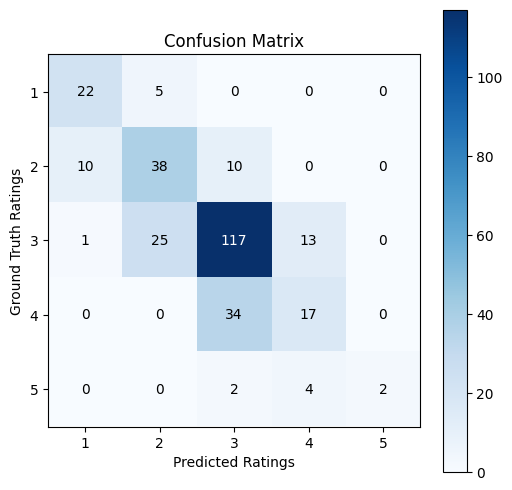

In [11]:
# figure_name = f"Confusion_Matrix_{os.path.splitext(model_name)[0]}.png"
figure_name = f"Confusion_Matrix_{os.path.splitext(os.path.basename(model_path))[0] + '.png'}"
figure_path = os.path.join(results_path, figure_name)

# Plot the confusion matrix as a heatmap with annotations
plt.figure(figsize=(6, 6))
plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.xlabel('Predicted Ratings')
plt.ylabel('Ground Truth Ratings')
plt.title('Confusion Matrix')
plt.xticks(np.arange(5), np.arange(1, 6))
plt.yticks(np.arange(5), np.arange(1, 6))

# Add text annotations for true positives and false positives
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        # Customize text color for light blue boxes (when the value is high)
        if conf_matrix[i, j] > conf_matrix.max() / 2:
            plt.text(j, i, str(conf_matrix[i, j]), ha='center', va='center', color='white')
        else:
            plt.text(j, i, str(conf_matrix[i, j]), ha='center', va='center', color='black')
plt.savefig(figure_path)
plt.show()

### 4.3 Plot Distribution

In [26]:
csv_file = "/home/maxgan/WORKSPACE/UNI/BA/TIQ/assets/DatasetSubjective/Persons/Person_5_arktip/img_scores.csv"
output_image_path = "/home/maxgan/WORKSPACE/UNI/BA/TIQ/assets/DatasetSubjective/Persons/Person_5_arktip/rating_distribution.png"

In [27]:
data = pd.read_csv(csv_file, header=None, skiprows=1)

print(data)
# Map rating values to their corresponding labels
rating_labels = {
    1: "Bad",
    2: "Insufficient",
    3: "Fair",
    4: "Good",
    5: "Excellent"
}
data["Rating_Label"] = data[1].map(rating_labels)

# Group data by Rating_Label and count occurrences
class_counts = data["Rating_Label"].value_counts().sort_index()
print(len(class_counts))
# Calculate total number of images
total_images = class_counts.sum()

                                                   0  1         2  \
0     1011ILSVRC2013_train_00012231.JPEG_I3_Q21.jpeg  1  0.137100   
1      1018ILSVRC2013_train_00006324.JPEG_I1_Q3.jpeg  1  0.000876   
2    10110ILSVRC2013_train_00057322.JPEG_I3_Q21.jpeg  3  0.000866   
3     10102ILSVRC2013_train_00057295.JPEG_I1_Q7.jpeg  1  0.000862   
4     1005ILSVRC2013_train_00016725.JPEG_I5_Q90.jpeg  4  0.001266   
..                                               ... ..       ...   
893   1031ILSVRC2013_train_00045698.JPEG_I4_Q37.jpeg  4  0.250790   
894  10265ILSVRC2013_train_00057859.JPEG_I2_Q11.jpeg  2  0.326890   
895  10277ILSVRC2013_train_00052727.JPEG_I4_Q30.jpeg  3  0.295630   
896    1043ILSVRC2013_train_00012531.JPEG_I1_Q5.jpeg  1  0.300650   
897   1023ILSVRC2013_train_00015533.JPEG_I4_Q40.jpeg  3  0.713830   

                        3  
0    24-Jan-2023 12:03:13  
1    24-Jan-2023 12:03:22  
2    24-Jan-2023 12:03:30  
3    24-Jan-2023 12:03:39  
4    24-Jan-2023 12:03:47  
.. 

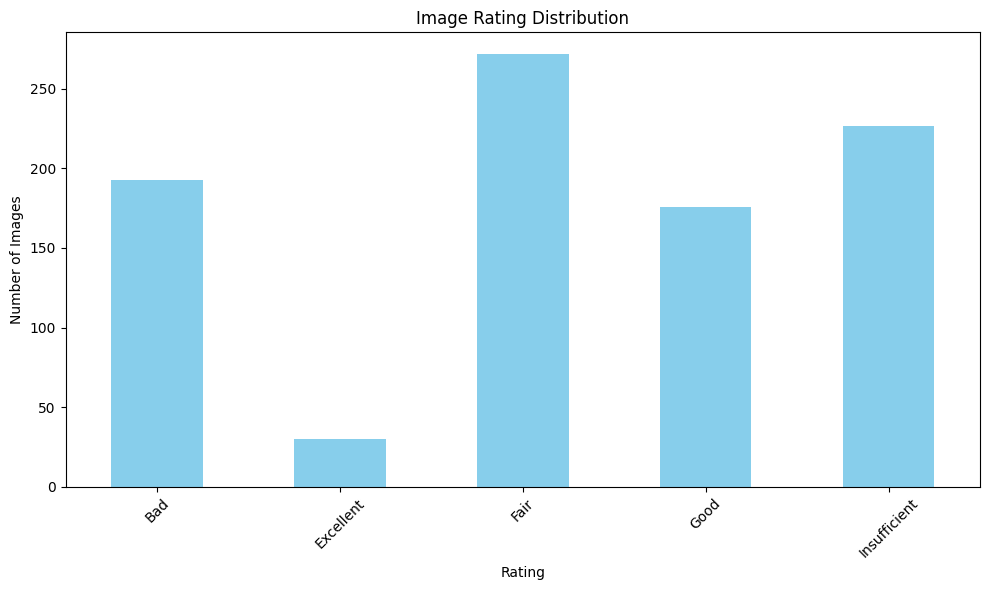

Rating Distribution Table:
Rating_Label
Bad             193
Excellent        30
Fair            272
Good            176
Insufficient    227
Name: count, dtype: int64


In [28]:
# Create a bar chart
plt.figure(figsize=(10, 6))
class_counts.plot(kind="bar", color='skyblue')
plt.title("Image Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.tight_layout()
# plt.savefig(output_image_path)
plt.show()
# Display the table
print("Rating Distribution Table:")
print(class_counts)

# 5. Run Model